<a href="https://colab.research.google.com/github/AnaMarijaKarcas/maskRcnn/blob/main/modelEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Update CUDA for TF 2.5
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
# Check if package has been installed
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
# Upgrade Tensorflow
!pip install --upgrade tensorflow==2.5.0

--2023-04-21 18:01:04--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430460776 (411M) [application/x-deb]
Saving to: ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’

libcudnn8_8.1.0.77- 100%[===================>] 410.52M   166MB/s    in 2.5s    

2023-04-21 18:01:06 (166 MB/s) - ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’ saved [430460776/430460776]

dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.7.0.84-1+cuda11.8) ...
Setting up libcudnn8 (8.1.0.77-1+c

In [2]:
!wget https://psfiles.link/project/mask_rcnn_colab/mrcnn_demo_PIBVGJTEFX.zip
!unzip mrcnn_demo_PIBVGJTEFX.zip
import sys
sys.path.append("/content/maskrcnn_colab/mrcnn_demo")
from m_rcnn import *
from visualize import random_colors, get_mask_contours, draw_mask
%matplotlib inline

--2023-04-21 18:03:47--  https://psfiles.link/project/mask_rcnn_colab/mrcnn_demo_PIBVGJTEFX.zip
Resolving psfiles.link (psfiles.link)... 34.90.26.83
Connecting to psfiles.link (psfiles.link)|34.90.26.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59799 (58K) [application/zip]
Saving to: ‘mrcnn_demo_PIBVGJTEFX.zip’

mrcnn_demo_PIBVGJTE 100%[===================>]  58.40K  --.-KB/s    in 0.09s   

2023-04-21 18:03:48 (615 KB/s) - ‘mrcnn_demo_PIBVGJTEFX.zip’ saved [59799/59799]

Archive:  mrcnn_demo_PIBVGJTEFX.zip
   creating: maskrcnn_colab/
   creating: maskrcnn_colab/mrcnn_demo/
  inflating: maskrcnn_colab/mrcnn_demo/config.py  
  inflating: maskrcnn_colab/mrcnn_demo/model.py  
  inflating: maskrcnn_colab/mrcnn_demo/m_rcnn.py  
  inflating: maskrcnn_colab/mrcnn_demo/parallel_model.py  
  inflating: maskrcnn_colab/mrcnn_demo/utils.py  
  inflating: maskrcnn_colab/mrcnn_demo/visualize.py  
VERS 0.5 - updated 11/03/2023


/content/maskrcnn_colab/mrcnn_demo/model.py:2378: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


... done downloading pretrained model!


In [3]:


test_model, inference_config = load_inference_model(1, "/content/drive/MyDrive/mask_rcnn_object_0008.h5")




Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/drive/MyDrive/mask_rcnn_object_0008.h5


In [21]:
annotations_path1 = "/content/drive/MyDrive/val/annotations/instances_default.json"

dataset_val = load_image_dataset(os.path.join("/content/", annotations_path1), "/content/drive/MyDrive/val/images", "train")



Annotation json path:  /content/drive/MyDrive/val/annotations/instances_default.json


In [15]:
def model_evaluation(dataset_val, test_model, inference_config):
    APs = []
    print("Testing the model on {} validation images.".format(len(dataset_val.image_ids)))
    for image_id in dataset_val.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = test_model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    return APs


In [23]:
inference_config = InferenceConfig(num_classes=dataset_val.count_classes())
test_model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="/content/drive/MyDrive/empty")
test_model.load_weights('/content/drive/MyDrive/mask_rcnn_object_0001.h5', by_name=True)

APs = model_evaluation(dataset_val, test_model, inference_config)
print("mAP: ", np.mean(APs))



Testing the model on 21 validation images.
mAP:  1.0


Annotation json path:  /content/drive/MyDrive/val/annotations/instances_default.json


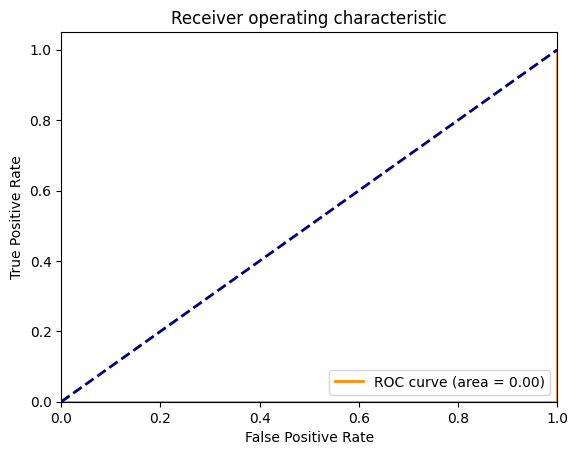

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load validation set and ground truth labels
dataset_val = load_image_dataset(os.path.join("/content/", annotations_path1), "/content/drive/MyDrive/val/images", "val")
y_true = dataset_val.class_ids

# Get predicted scores for each image in validation set
y_score = []
for image_id in dataset_val.image_ids:
    # Load image and run object detection
    image, _, _, _, _ = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    results = test_model.detect([image], verbose=0)
    r = results[0]
    # Append score for positive class (object present) or 0 for negative class (object not present)
    if len(r['class_ids']) > 0:
        y_score.append(r['scores'][0])
    else:
        y_score.append(0)

# Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
